<a href="https://colab.research.google.com/github/dev-newsoft/FinalProject/blob/main/mypro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import random
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
 #set parameter

w_RSU=[-50,0,0]

velocity=15  # m/s
T = 40 # s eche period
N = 40 # number of period
tt=T/N
movement=tt*velocity
f_u_max = 20e9 # GHz

f_k=1.2e9 #1.2 GHz
f_u_k=1.6e9 #1.6 GHz
f_rc_k=1.4e9 #1.6 GHz
B0=1e-3 #-30 dB
B=2e6 #MHz
p_k=0.5 #w
a_k=0.7
a_u=0.8
N0=2e-16 #-130dBm/Hz
t_k=1.5 #s
p_u=0.8 #w

q=[5,10,100] # uav first location

#rsu config

P_0=39.03 #w
P_i=89.07 #w
U_t= 100.0 #m/s
v_0= 3.6 #m/s
A=0.5030 #m2
a_max = 5 #m/s2 acceleration
v_max=20 # m/s speed

d_0=0.4
ss=0.1
pp= 1.204 #kg/m3

location=[]
locat_u=[]


def initial():
  #[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
  s_initial=[]

  for i in range(12):
    initial=[]
    #Vehicle Location half odd even
    if i % 2:
      col = []
      col.append(random.randint(-500,500))
      col.append(0)
      col.append(0)
      initial.append(col)
    else:
      col = []
      col.append(0)
      col.append(random.randint(-500,500))
      col.append(0)
      initial.append(col)

  #UAV Location
    initial.append(q)

    #input size
    initial.append(random.randint(200000,2000000))
    #cycles to process
    initial.append(random.randint(500,1500))

    s_initial.append(initial)



  return s_initial

def update_uav_location(u):


    M=4
    action_space = np.array(np.arange(M * 11 ** 3))
    action = np.random.randint(1000, 5000)
    speed=v_max
    acceleration=a_max

    theta = int(action / 121) * 0.1 * np.pi * 2
    dis_fly =speed*tt + (( acceleration)*tt**2)/2

    dx_uav = dis_fly * math.cos(theta)
    dy_uav = dis_fly * math.sin(theta)
    u_=[]
    u_.extend(u)
    u_[0] =int((u[0] + dx_uav))
    u_[1] = int((u[1] + dy_uav))

    if(u_[0]>500):
      u_[0]=u_[0]-1000
    if(u_[0]<-500):
      u_[0]=u_[0]+1000

    if(u_[1]>500):
      u_[1]=u_[1]-1000
    if(u_[1]<-500):
      u_[1]=u_[1]+1000
    u_[2]=100
    return u_

def next_step(last_step):

  u_=update_uav_location(last_step[0][1])

  #[w= Vehicle Location,q= UAV Location,  D= input size ,C= cycles to process]
  next=[]
  for last in last_step:
    initial=[]
    #Vehicle Location
    col = []
    for locat in last[0]:
      if(locat!=0):
        t1=locat+random.randint(1,movement)  # movement
        if(t1>500):
          col.append(t1-1000)
        else:
          col.append(t1)
      else:
        col.append(0)

    initial.append(col)


  #UAV Location
    initial.append(u_)
    #input size
    initial.append(random.randint(200000,2000000))
    #cycles to process
    initial.append(last[3])

    next.append(initial)

  location.append(next)

  return next





In [ ]:
def calculate_Energy(step):

  v=random.randint(1,v_max)

  print("\n---------------\n")
  E_f=0.5 * d_0 * pp * A * ss * (v ** 3)+P_0 * (1+ 3 * v**3 /U_t**2)+P_i * ((1+v**4/4*v_0**4)**0.5-(v**2/2*v_0**2))
  print("Energy_uav_movment:", E_f)
  Energy_Consumption=E_f

  i=1
  for last in step:
    print("\n---------------\n")
    print("[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]")
    print("Situation Vehicle "+str(i)+" => "+str(last) )
    i+=1
    h = B0/(math.pow((np.linalg.norm(np.array(last[0]) - np.array(last[1]))),2))
    R=(B/12)*math.log2(1+(12*((p_k*h)/(N0*B))))

    T_l_k = (1-a_k)*last[2]/f_k
    T_o_k=a_k*last[2]/R
    print("Time_Offloading_uav", T_o_k)

    E_k=1e-26 * f_u_k ** 2 * min(f_u_k*(t_k-T_o_k) ,(a_k*last[2]*last[3]) )

    print("Energy_uav_Computing", E_k)

    # in rsu
    E_rc_k=0

    if(f_u_k*(T_o_k) > (a_k*last[2]*last[3])):
      ggg=1
      print("procesing finish in uav")
    else:
      print("procesing start in rsu")

      D_r_k=a_k*last[2]- f_u_k*T_o_k/last[3] #remain tasks
      print("D_k=",last[2] ," D_r_k=",D_r_k)

      h_r = B0/math.pow((np.linalg.norm(np.array(last[1]) - w_RSU)),2)
      R_k=(B/12)*math.log2(1+12*((p_u*h_r)/(B*N0)))
      T_R_k= D_r_k/R_k #relay time
      print("Time_rsu:", T_R_k)

      E_rc_k=1e-26 * f_rc_k ** 2 * min(f_rc_k*(t_k-T_R_k) ,(D_r_k*last[3]) )
      print("Energy_rsu", E_rc_k)

    Energy_Consumption =Energy_Consumption+E_rc_k+E_k
  print("\n---------------\n")
  print("Energy_Consumption", Energy_Consumption)

  return



In [ ]:
s_initial=initial()

In [ ]:

for step in range(20):

    # print("\n------- step number =",step," --------\n")

    calculate_Energy(s_initial)
    s_initial=next_step(s_initial)



---------------

Energy_uav_movment: 40.43674904628347

---------------

[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
Situation Vehicle 1 => [[0, 407, 0], [5, 10, 100], 300986, 978]
Time_Offloading_uav 0.19449710205246495
Energy_uav_Computing 5.27500839936
procesing finish in uav

---------------

[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
Situation Vehicle 2 => [[-388, 0, 0], [5, 10, 100], 659040, 788]
Time_Offloading_uav 0.42414195346441563
Energy_uav_Computing 9.306277478399998
procesing finish in uav

---------------

[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
Situation Vehicle 3 => [[0, 438, 0], [5, 10, 100], 1260791, 549]
Time_Offloading_uav 0.8409116822235717
Energy_uav_Computing 12.40376272128
procesing finish in uav

---------------

[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
Situation Vehicle 4 => [[-356, 0, 0], [5, 10, 100], 1206140, 1115]
Time_Offloadin

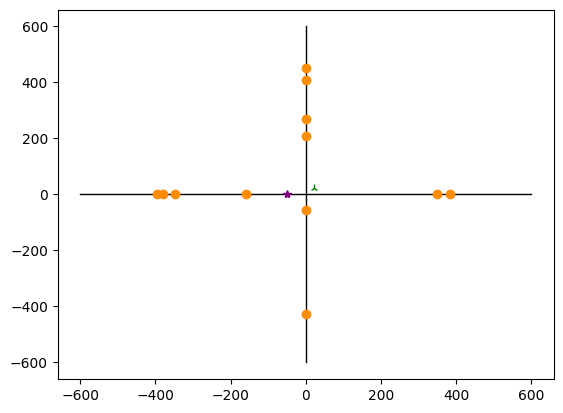

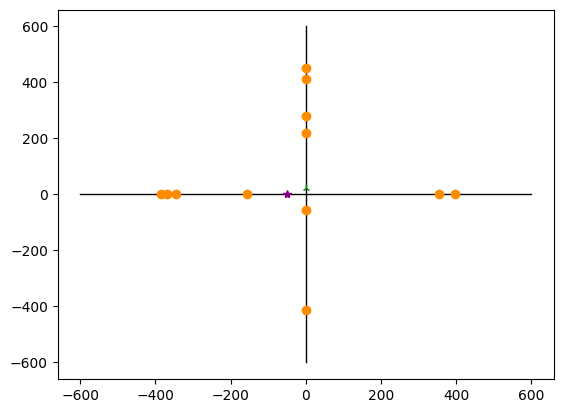

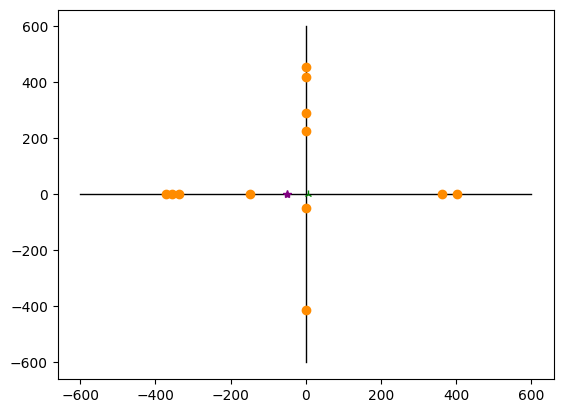

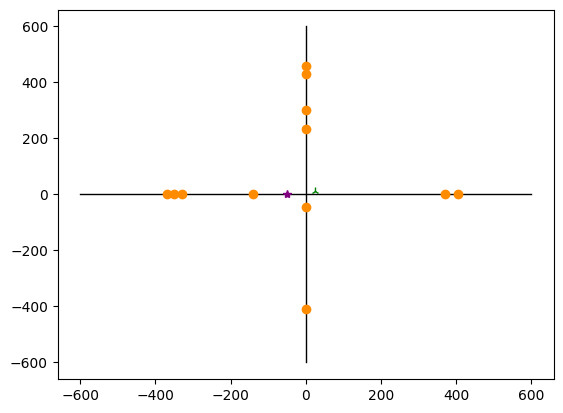

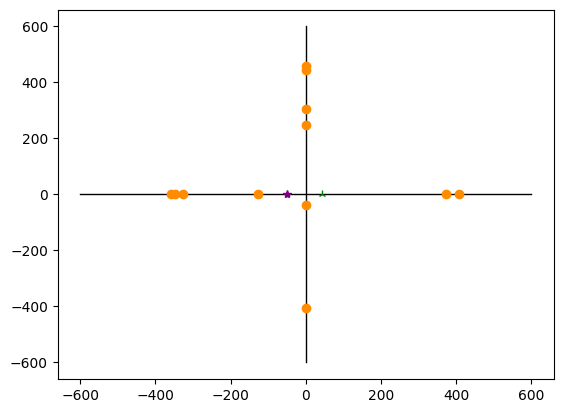

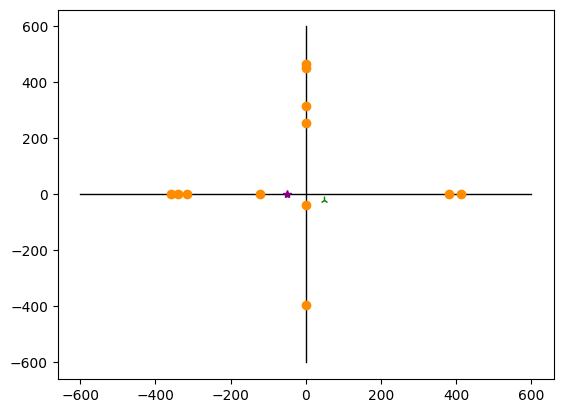

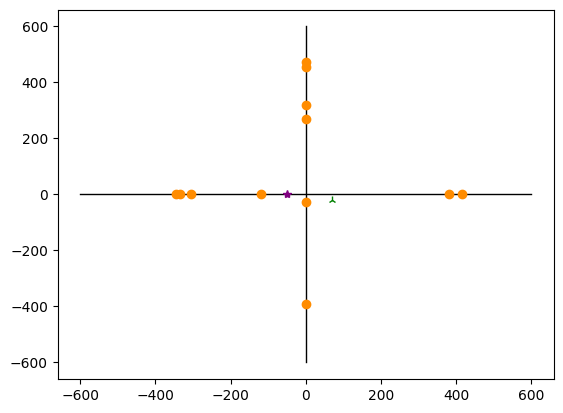

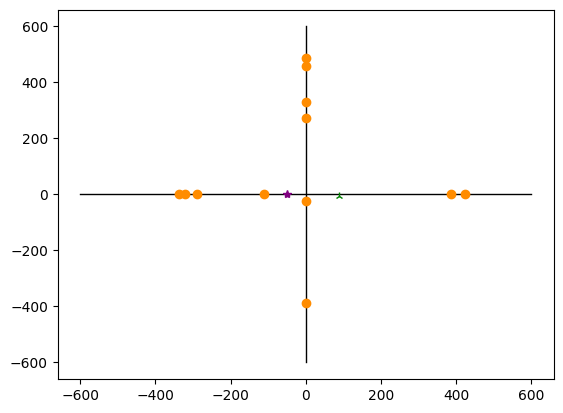

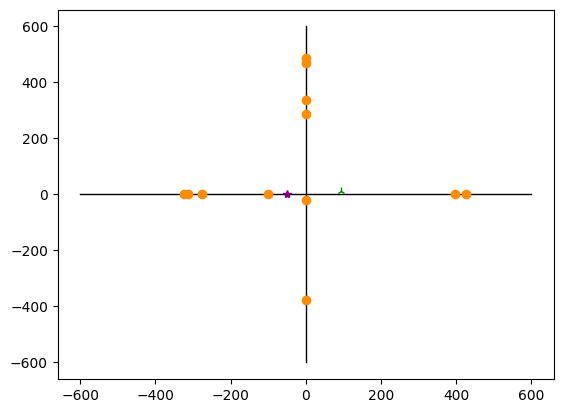

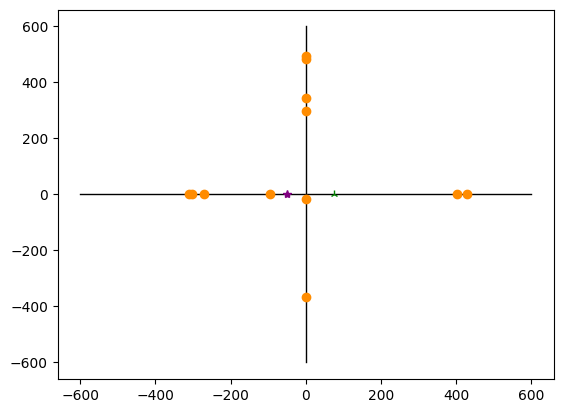

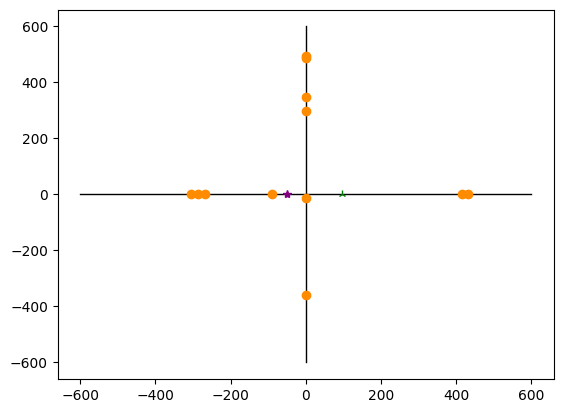

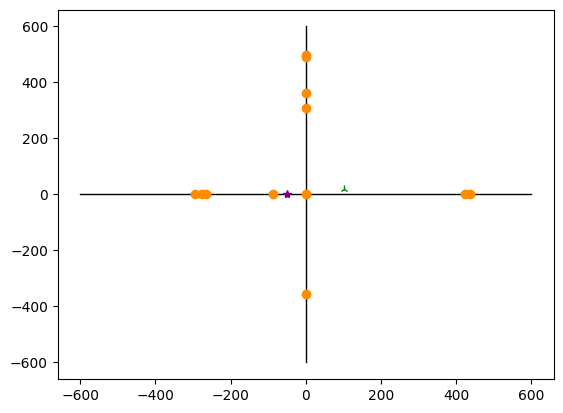

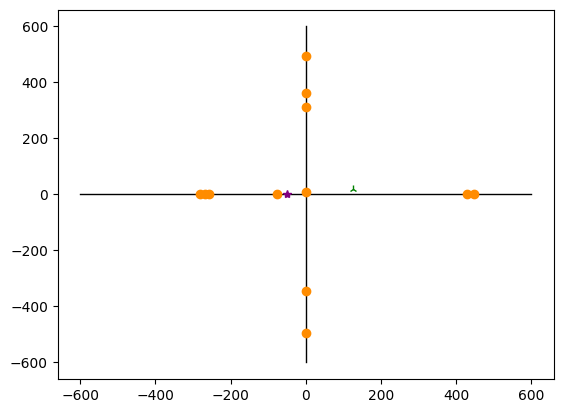

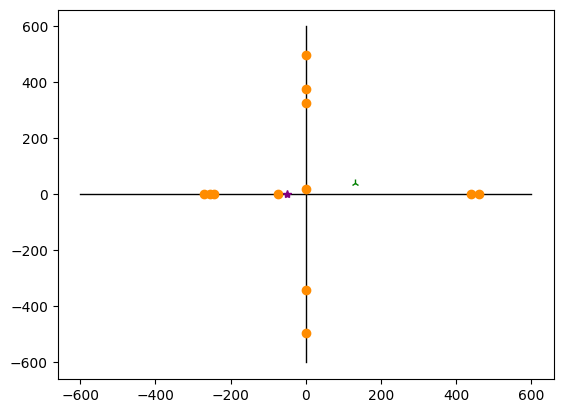

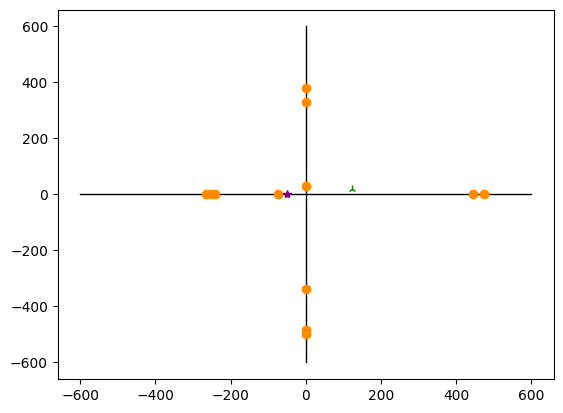

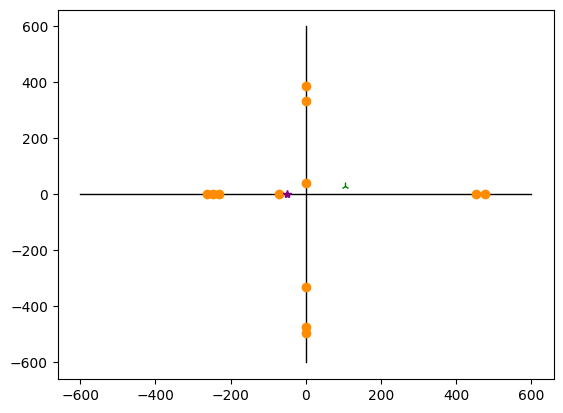

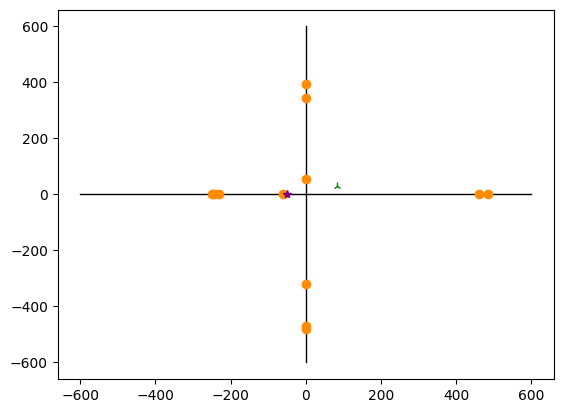

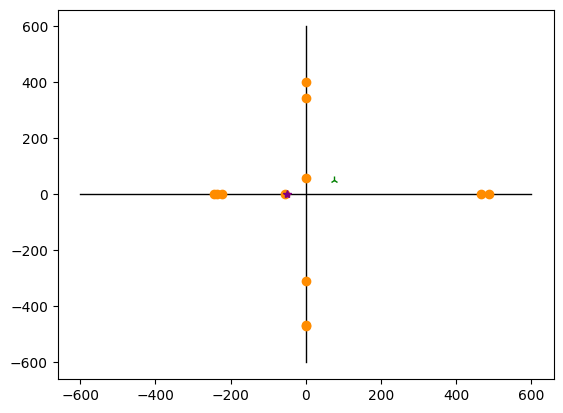

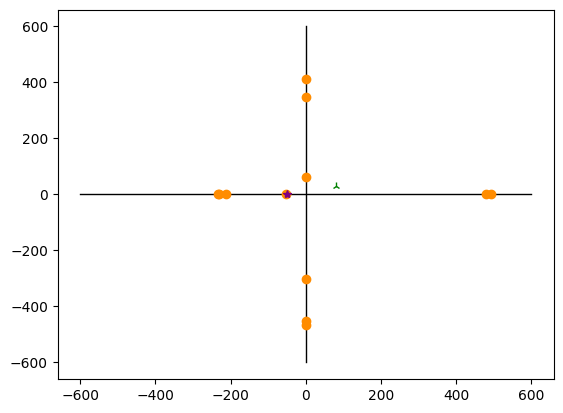

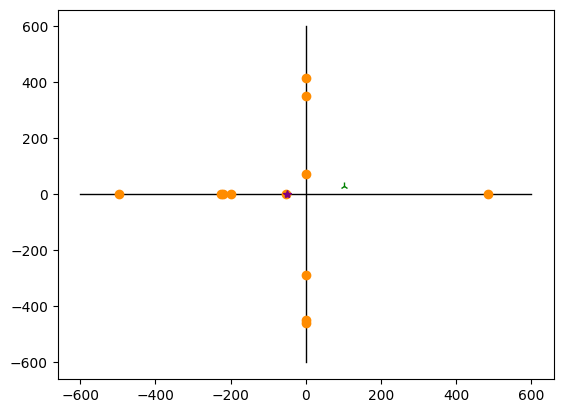

In [ ]:
# def update_plot(step):
for step in location:

  xpoint=[]
  ypoint=[]

  plt.plot([600, -600], [0, 0], color="k", lw=1, linestyle='solid', label="_not in legend")
  plt.plot([0, 0], [600, -600], color="k", lw=1, linestyle='solid', label="_not in legend")

  for last in step:
      xpoint.append(last[0][0])
      ypoint.append(last[0][1])

  plt.plot(xpoint, ypoint, linestyle='none',color='darkorange', marker='o')

  plt.plot(step[0][1][0], step[0][1][1], linestyle='none',color='green', marker='2')

  plt.plot(w_RSU[0], w_RSU[1], linestyle='none',color='purple', marker='*')

  plt.show()

